In [1]:
from os import path as osp
import numpy as np
from PIL import Image
import torch
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from diffusers.utils import make_image_grid
from src.utils.mask_v2 import Maskerv2 as Masker
from src.utils.mask import get_mask_location
from src.preprocess.openpose import OpenPose
from src.preprocess.humanparsing import Parsing
from src.dataset.dresscode import DressCodeDataset

In [5]:
def mask2agn(mask: np.array) -> Image.Image:
    mask = torch.from_numpy(mask)
    body_tensor = pil_to_tensor(body)
    agnostic_tensor = torch.where(mask, torch.ones_like(body_tensor) * 127, body_tensor)
    agn_img = to_pil_image(agnostic_tensor)
    return agn_img

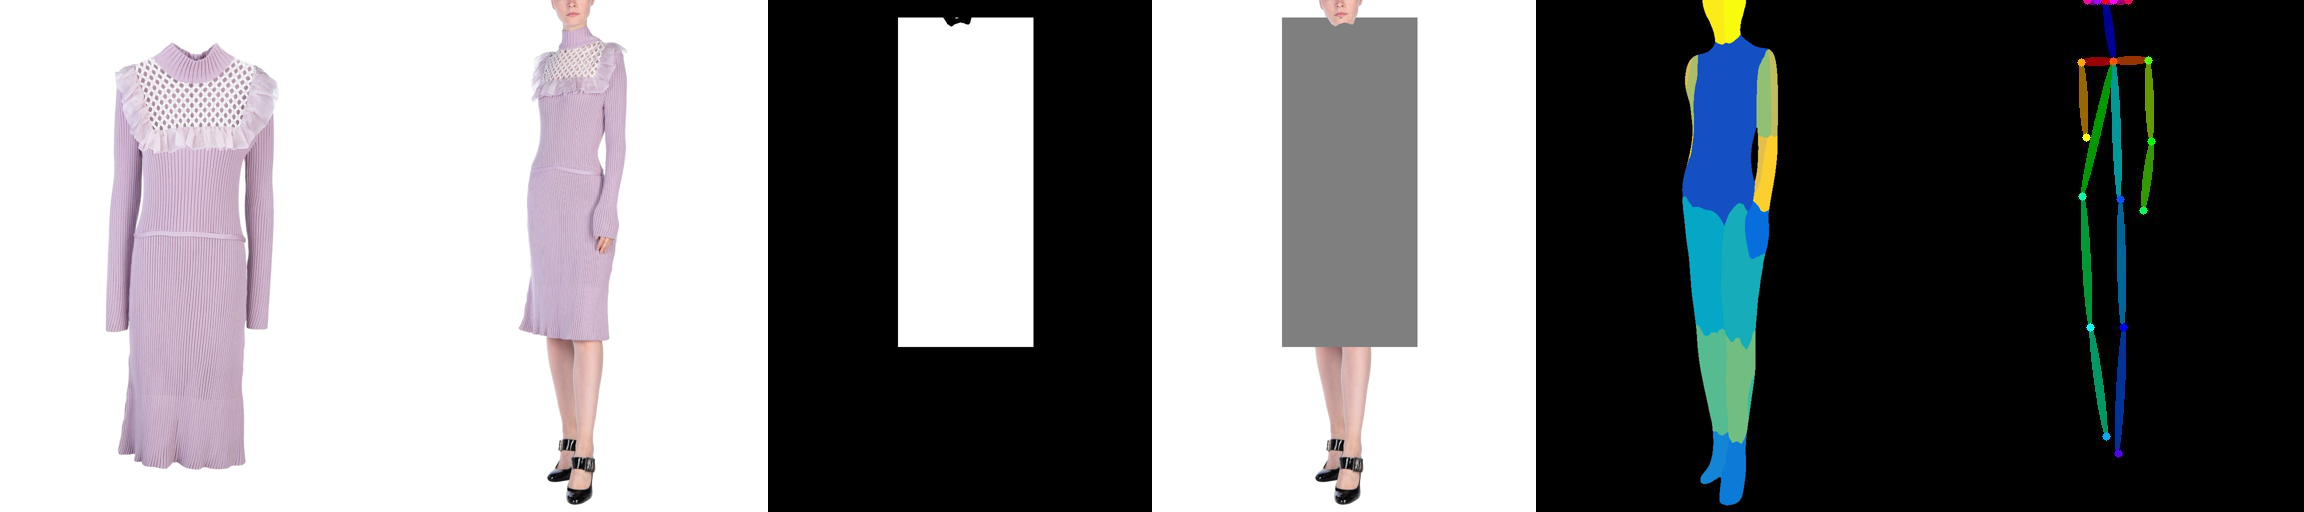

In [39]:
category = 'dresses'
idx = '027883'
body_path = f'/hosjiu/data/DressCode/{category}/images/{idx}_0.jpg'
garment_path = f'/hosjiu/data/DressCode/{category}/images/{idx}_1.jpg'
mask_path = f'/hosjiu/data/DressCode/{category}/mask_v2/{idx}_0.jpg'
agnostic_path = f'/hosjiu/data/DressCode/{category}/agnostic_v2/{idx}_0.jpg'
dense_path = f'/hosjiu/data/DressCode/{category}/dense_modified/{idx}_0.jpg'
skeleton_path = f'/hosjiu/data/DressCode/{category}/skeleton_modified/{idx}_0.jpg'

w, h = (384, 512)
body = Image.open(body_path).resize((w, h))
garment = Image.open(garment_path).resize((w, h))
mask = Image.open(mask_path).resize((w, h))
agnostic = Image.open(agnostic_path).resize((w, h))
dense = Image.open(dense_path).resize((w, h))
skeleton = Image.open(skeleton_path).resize((w, h))

make_image_grid([garment, body, mask, agnostic, dense, skeleton], rows=1, cols=6)

In [7]:
print(pil_to_tensor(dense).shape)
print(pil_to_tensor(skeleton).shape)

torch.Size([3, 512, 384])
torch.Size([3, 512, 384])


In [8]:
masker = Masker()

2024-12-21 03:06:24.015889959 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.12: cannot open shared object file: No such file or directory

2024-12-21 03:06:24.015924662 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.
2024-12-21 03:06:25.385652232 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_

In [9]:
gpu_id = 0
human_parser = Parsing(gpu_id)
openpose = OpenPose(gpu_id)

2024-12-21 03:06:27.076412218 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.12: cannot open shared object file: No such file or directory

2024-12-21 03:06:27.076441187 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.
2024-12-21 03:06:27.679724140 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_

In [10]:
# mask v1
category = 'lower_body'
keypoints, _ = openpose(body)
body_parse, _  = human_parser(body)
mask_v1, mask_gray, tmp, _ = get_mask_location(
    model_type='hd',
    category=category,
    model_parse=body_parse,
    keypoint=keypoints,
    width=w,
    height=h
)

# mask v2 (dilated-relaxed mask)
mask_v2 = masker.create_mask(body, category=category, return_img=True)

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


In [11]:
mask_v2.save('/tmp/mask.jpg')

In [25]:
# convert grayscale image to *pure* binary one.
mask = Image.open('/tmp/mask.jpg').convert('L')
mask = mask.point(lambda pixel: 255 if pixel > 125 else 0)
mask = mask.convert('1')

In [33]:
np.array(mask, dtype=np.int8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

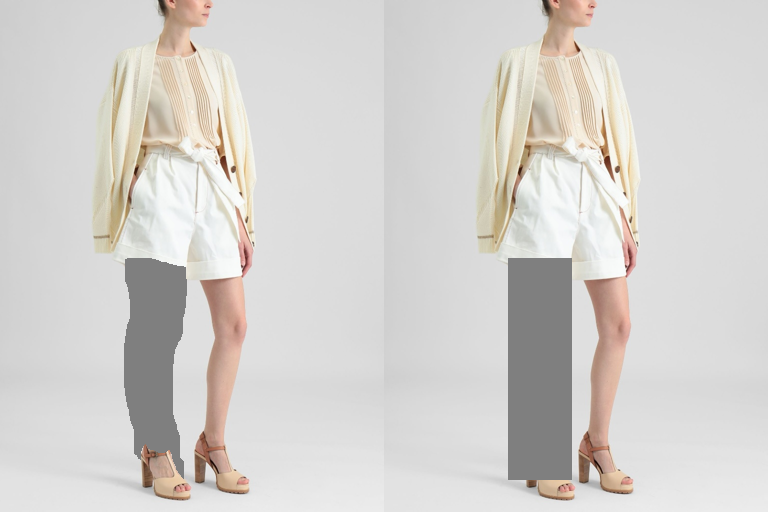

In [49]:
agn_v1 = mask2agn(np.array(mask_v1))
agn_v2 = mask2agn(np.array(mask_v2))
make_image_grid([agn_v1, agn_v2], rows=1, cols=2)

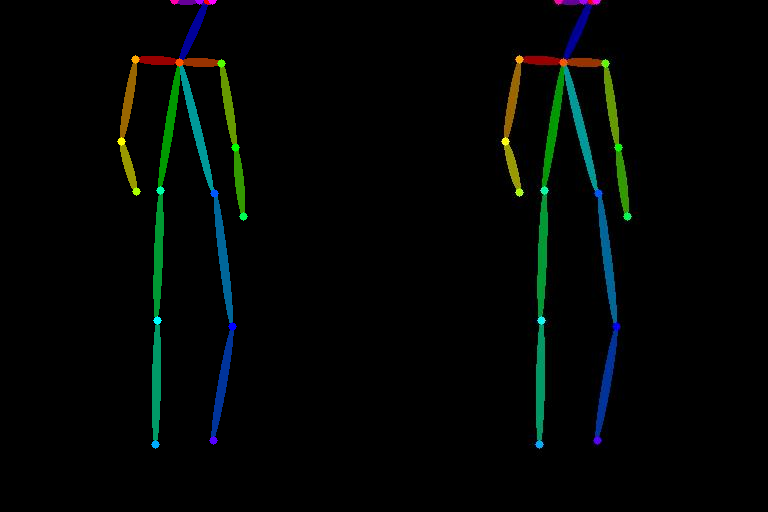

In [45]:
from einops import rearrange
import torchvision

detected_map = openpose(body, hand_and_face=False)[1]
my_skeleton = Image.fromarray(detected_map)

make_image_grid([my_skeleton, skeleton], 1, 2)

### DressCode Dataset

In [2]:
dataroot_path = osp.join('/hosjiu/data/DressCode/')

w, h = (384, 512)
phase = 'test'
dataset = DressCodeDataset(
    dataroot_path,
    phase=phase,
    h=h,
    w=w,
    use_dilated_relaxed_mask=True)

print(f'Dataset Size ({phase}): {len(dataset)}')

Dataset Size (test): 5391


In [3]:
sample = dataset[0]
for k, v in sample.items():
    if isinstance(v, torch.Tensor):
        print(f'{k}: {v.shape}')

original_image: torch.Size([3, 512, 384])
image: torch.Size([3, 512, 384])
masked_image: torch.Size([3, 512, 384])
mask: torch.Size([1, 512, 384])
densepose: torch.Size([3, 512, 384])
cloth_raw: torch.Size([3, 512, 384])


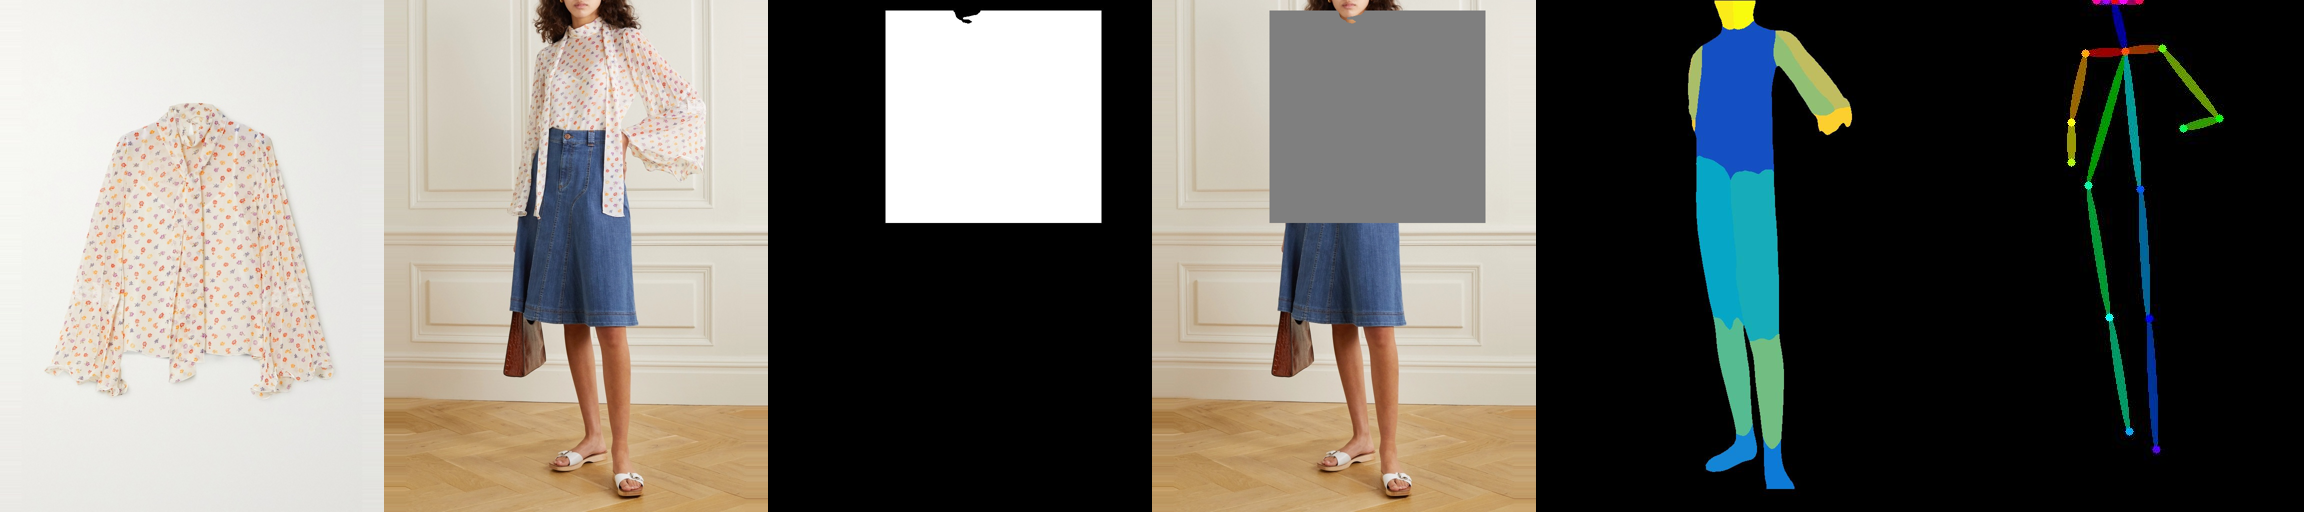

In [4]:
items = dataset.get_random_sample()
make_image_grid([v for v in items.values()], 1, len(items.keys()))